In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import scipy
import requests
import json
import datetime

In [26]:
transfers_df = pd.read_csv('data/combined_transfers_1_year.csv')
# address_type_df = pd.read_csv('data/node_table.csv')

In [22]:
# df = pd.read_csv('data/combined_transfers.csv')
new_df = df[df['timestamp'] > 1696118399]
new_df.to_csv('data/combined_transfers_1_year.csv')

In [28]:
transfers_df['timestamp'] = pd.to_datetime(transfers_df['timestamp'], unit='s')

transfers_df['date'] = transfers_df['timestamp'].dt.date

transfers_per_day = transfers_df.groupby(['date', 'token']).size().unstack(fill_value=0)

In [29]:
distinct_tokens = transfers_df['token'].unique()
print(distinct_tokens)

['AAVE' 'stkAAVE' 'aEthAAVE' 'aEthWETH' 'aEthUSDT' 'aEthUSDC' 'COMP'
 'cCOMP' 'cWETHv3' 'cUSDTv3' 'cUSDCv3' 'aOptWETH' 'aOptUSDC' 'aOptUSDT'
 'OptAAVE' 'aOptAAVE' 'cOptWETH' 'cOptUSDC' 'cOptUSDT' 'OptCOMP'
 'aPolWETH' 'aPolUSDC' 'aPolUSDT' 'PolAAVE' 'aPolAAVE' 'cPolUSDT'
 'PolCOMP' 'aBasWETH' 'aBasUSDC' 'cBasWETH' 'cBasUSDC' 'BasCOMP'
 'aArbWETH' 'aArbUSDC' 'aArbUSDT' 'ArbAAVE' 'aArbAAVE' 'cArbWETH'
 'cArbUSDC' 'cArbUSDT' 'ArbCOMP']


In [15]:
transfers_df['timestamp'] = transfers_df['timestamp'].astype(int)

# transfers_df = transfers_df[transfers_df['timestamp'] > 1696118399000000000]
# filtered_df = transfers_df[transfers_df['timestamp'] > 1696118399000000000]
# filtered_df = transfers_df[transfers_df['date'] > datetime.date(2023, 9, 30)]

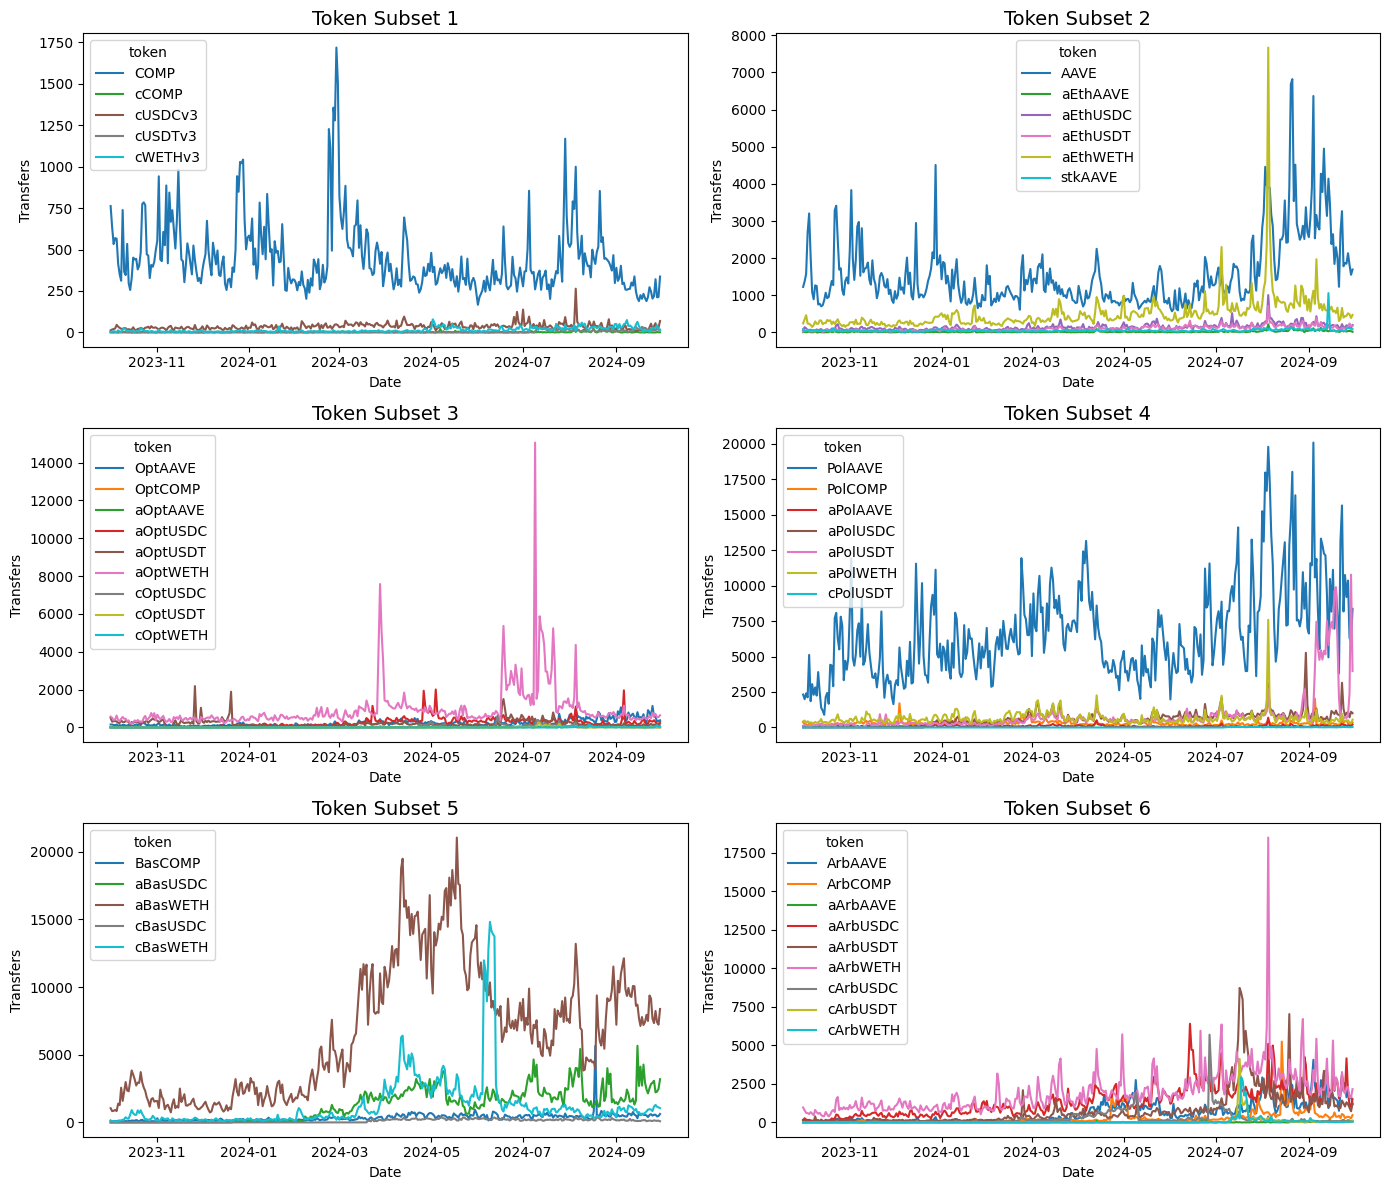

In [17]:
token_subsets = [
    ['COMP', 'cCOMP', 'cWETHv3', 'cUSDTv3', 'cUSDCv3'],
    ['AAVE', 'stkAAVE', 'aEthAAVE', 'aEthWETH', 'aEthUSDT', 'aEthUSDC'],
    ['aOptWETH', 'aOptUSDC', 'aOptUSDT', 'OptAAVE', 'aOptAAVE', 'cOptWETH', 'cOptUSDC', 'cOptUSDT', 'OptCOMP'],
    ['aPolWETH', 'aPolUSDC', 'aPolUSDT', 'PolAAVE', 'aPolAAVE', 'cPolUSDT', 'PolCOMP'],
    ['aBasWETH', 'aBasUSDC', 'cBasWETH', 'cBasUSDC', 'BasCOMP'],
    ['aArbWETH', 'aArbUSDC', 'aArbUSDT', 'ArbAAVE', 'aArbAAVE', 'cArbWETH', 'cArbUSDC', 'cArbUSDT', 'ArbCOMP']
] # subset per market

# token_subsets = [
#     ['COMP', 'cCOMP', 'OptCOMP', 'PolCOMP', 'BasCOMP', 'ArbCOMP'],
#     ['cWETHv3', 'aEthWETH', 'aOptWETH', 'aPolWETH', 'aBasWETH', 'aArbWETH', 'cOptWETH', 'cBasWETH', 'cArbWETH'],
#     ['cUSDTv3', 'aEthUSDT', 'aOptUSDT', 'aPolUSDT', 'aArbUSDT', 'cOptUSDT', 'cPolUSDT', 'cArbUSDT'],
#     ['cUSDCv3', 'aEthUSDC', 'aOptUSDC', 'aPolUSDC', 'aBasUSDC', 'aArbUSDC', 'cOptUSDC', 'cBasUSDC', 'cArbUSDC'],
#     ['AAVE', 'stkAAVE', 'OptAAVE', 'PolAAVE', 'ArbAAVE'],
#     ['aEthAAVE', 'aOptAAVE', 'aPolAAVE', 'aArbAAVE']
# ] # subset per token

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, tokens in enumerate(token_subsets):
    row = i // 2
    col = i % 2

    subset_df = transfers_df[transfers_df['token'].isin(tokens)]

    transfers_per_day_subset = subset_df.groupby(['date', 'token']).size().unstack(fill_value=0)

    # transfers_per_day_subset.plot(kind='area', stacked=True, colormap='tab10', ax=axes[row, col])
    transfers_per_day_subset.plot(kind='line', colormap='tab10', ax=axes[row, col])

    axes[row, col].set_title(f'Token Subset {i+1}', fontsize=14)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Transfers')

plt.tight_layout()

plt.show()

In [ ]:
# selected_tokens = ['COMP', 'cCOMP', 'cWETHv3', 'cUSDTv3', 'cUSDCv3']
# selected_tokens = ['AAVE', 'stkAAVE', 'aEthAAVE', 'aEthWETH', 'aEthUSDT', 'aEthUSDC']
# selected_tokens = ['aOptWETH', 'aOptUSDC', 'aOptUSDT', 'OptAAVE', 'aOptAAVE', 'cOptWETH', 'cOptUSDC', 'cOptUSDT', 'OptCOMP']
# selected_tokens = ['aPolWETH', 'aPolUSDC', 'aPolUSDT', 'PolAAVE', 'aPolAAVE', 'cPolUSDT', 'PolCOMP']
# selected_tokens = ['aBasWETH', 'aBasUSDC', 'cBasWETH', 'cBasUSDC', 'BasCOMP']
selected_tokens = ['aArbWETH', 'aArbUSDC', 'aArbUSDT', 'ArbAAVE', 'aArbAAVE', 'cArbWETH', 'cArbUSDC', 'cArbUSDT', 'ArbCOMP']

subset_df = transfers_df[transfers_df['token'].isin(selected_tokens)]

transfers_per_day_subset = subset_df.groupby(['date', 'token']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
# transfers_per_day_subset.plot(kind='area', stacked=True, colormap='tab10', figsize=(12, 8))
transfers_per_day_subset.plot(kind='line', colormap='tab10', figsize=(12, 8))

plt.title('Number of transfers per day per token', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of transfers', fontsize=12)

plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
G = nx.Graph()

for _, row in transfers_df.iterrows():
    from_address = row['from']
    to_address = row['to']
    
    G.add_edge(from_address, to_address)

# address_type_dict = pd.Series(address_type_df['type'].values, index=address_type_df['address']).to_dict()

# nx.set_node_attributes(G, address_type_dict, 'type')

In [34]:
print(f'Number of nodes: {len(G.nodes)}, number of edges: {len(G.edges)}')

Number of nodes: 792355, number of edges: 1464066


In [6]:
# address_type_df['type'].value_counts().reset_index(name='node_count')

,type,node_count
0,False,313557
1,True,15817


In [8]:
eoa_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == False]
sc_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == True]

eoa_degrees = [G.degree(n) for n in eoa_nodes]
sc_degrees = [G.degree(n) for n in sc_nodes]

avg_degree_eoa = sum(eoa_degrees) / len(eoa_degrees) if len(eoa_degrees) > 0 else 0
avg_degree_sc = sum(sc_degrees) / len(sc_degrees) if len(sc_degrees) > 0 else 0

print(f'Average degree of EOAs: {avg_degree_eoa}')
print(f'Average degree of smart contracts: {avg_degree_sc}')

Average degree of EOAs: 2.7677551449975604
Average degree of smart contracts: 15.361383321742428


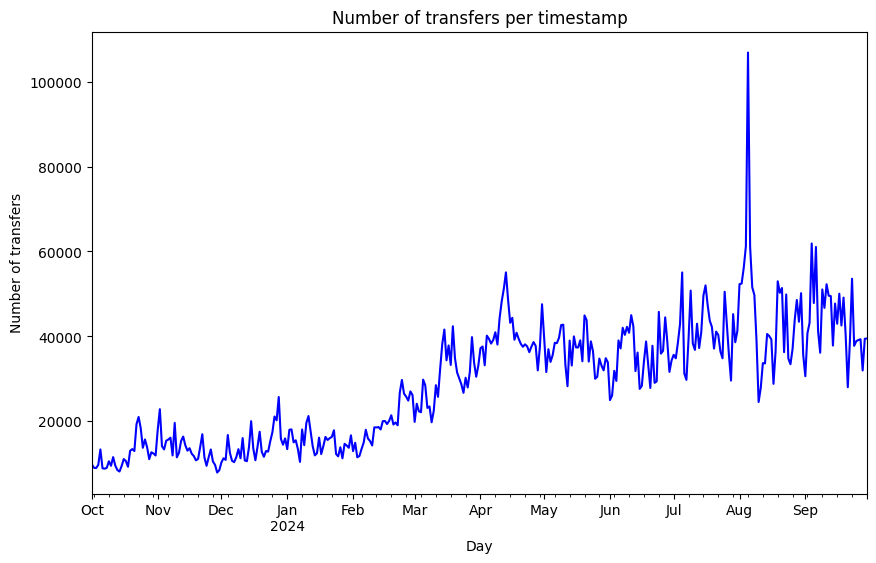

In [30]:
# transfers_df['timestamp'] = pd.to_datetime(transfers_df['timestamp'], unit='s')

transfers_per_day = transfers_df.resample('D', on='timestamp').size()

plt.figure(figsize=(10, 6))
transfers_per_day.plot(kind='line', color='blue', title='Number of transfers over time')
plt.xlabel('Day')
plt.ylabel('Number of transfers')
plt.show()

In [31]:
degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)

degree_df = pd.DataFrame(degree_list, columns=['Address', 'Degree'])

print(degree_df)

                                           Address  Degree
0       0x0000000000000000000000000000000000000000  574126
1       0x8be473dcfa93132658821e67cbeb684ec8ea2e74  117810
2       0x18cd499e3d7ed42feba981ac9236a278e4cdc2ee  110283
3       0xecd4bd3121f9fd604ffac631bf6d41ec12f1fafb   30763
4       0xe9e52021f4e11dead8661812a0a6c8627aba2a54   26389
...                                            ...     ...
792350  0xd38909fd6221a08be31946674927109c0858e108       1
792351  0x4a582f46d49315515cc54a10af123028ba1d0896       1
792352  0x33b0c9908935faf471e235d1652e993d2833ec4e       1
792353  0x4e8e066c0a977628bba4f9ea7b8a015340c816b2       1
792354  0x553111bf326e6e17cf21250339ba8aea343a0ea9       1

[792355 rows x 2 columns]


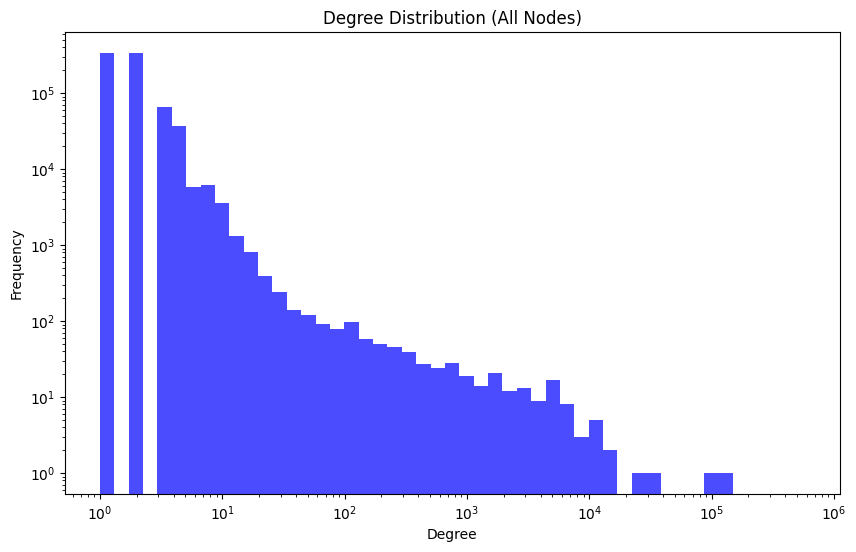

In [32]:
degrees = [G.degree(n) for n in G.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree distribution (all nodes)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

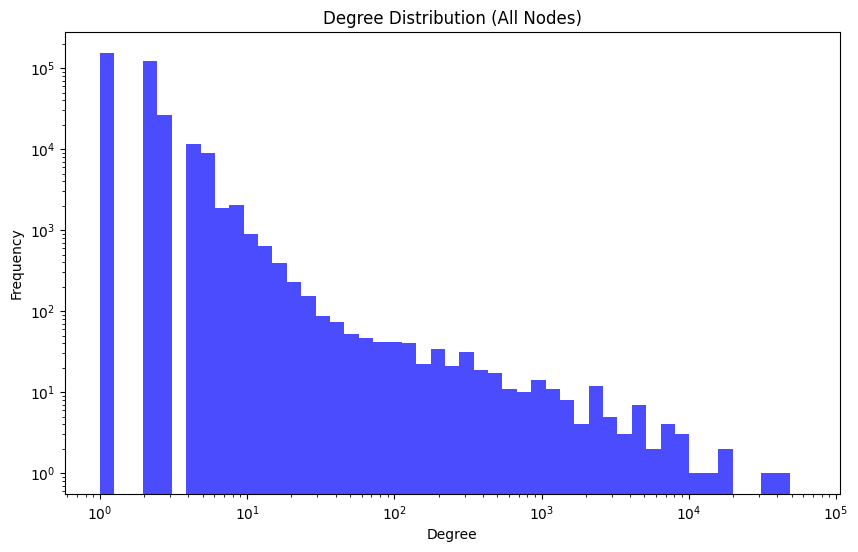

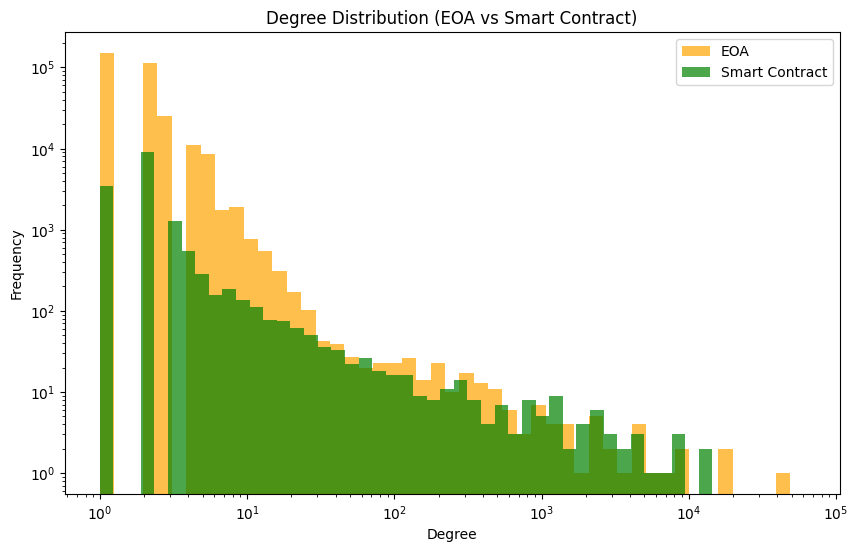

In [26]:
degrees = [G.degree(n) for n in G.nodes()]

eoa_degrees = [G.degree(n) for n, attr in G.nodes(data=True) if attr['type'] == False]
sc_degrees = [G.degree(n) for n, attr in G.nodes(data=True) if attr['type'] == True]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree distribution (all nodes)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(eoa_degrees, bins=np.logspace(np.log10(1), np.log10(max(eoa_degrees)), 50), color='orange', alpha=0.7, label='EOA')
plt.hist(sc_degrees, bins=np.logspace(np.log10(1), np.log10(max(sc_degrees)), 50), color='green', alpha=0.7, label='Smart Contract')
plt.xscale('log')
plt.yscale('log')
plt.title('Degree distribution (EOA vs smart contract)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [33]:
connected_components = list(nx.connected_components(G))

largest_component = max(connected_components, key=len)
largest_subgraph = G.subgraph(largest_component)

print(f"Largest component size: {len(largest_component)}")

Largest component size: 776400


In [37]:
print(f'Number of nodes: {len(largest_subgraph.nodes)}, number of edges: {len(largest_subgraph.edges)}')

Number of nodes: 776400, number of edges: 1455514


In [ ]:
# clustering_coefficient = nx.clustering(G)
average_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {average_clustering}")

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)
print(f"Betweenness centrality of a sample node: {list(betweenness_centrality.items())[:5]}")

In [ ]:
# Calculate degree assortativity (correlation between node degrees)
degree_assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity: {degree_assortativity}")